<a href="https://colab.research.google.com/github/Caoyexin/Learning/blob/main/Capstone%20project/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [146]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import numpy as np
import pandas_datareader.data as web

import statsmodels.api as sm
import statsmodels.tsa.api as tsa

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

In [3]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [4]:
from google.colab import files
uploaded = files.upload()

#from google.colab import drive
#drive.mount('/content/drive')

Saving AAPL.csv to AAPL.csv


In [5]:
!pip install pmdarima
from pmdarima.arima import auto_arima

     |████████████████████████████████| 1.5 MB 5.4 MB/s 
     |████████████████████████████████| 9.5 MB 15.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [6]:
!pip install fbprophet

In [7]:
from fbprophet import Prophet



# Data Wrangling

## Load dataset

In [8]:
#apple_df = data = pd.read_csv('/content/drive/My Drive/AAPL.csv')
apple_df = data = pd.read_csv('AAPL.csv')
apple_df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100751,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095495,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088485,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090676,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093304,73449600
5,1980-12-19,0.126116,0.126674,0.126116,0.126116,0.098999,48630400
6,1980-12-22,0.132254,0.132813,0.132254,0.132254,0.103817,37363200
7,1980-12-23,0.137835,0.138393,0.137835,0.137835,0.108198,46950400
8,1980-12-24,0.145089,0.145647,0.145089,0.145089,0.113892,48003200
9,1980-12-26,0.158482,0.159040,0.158482,0.158482,0.124405,55574400


In [9]:
apple_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10250.000000,10250.000000,10250.000000,10250.000000,10250.000000,1.025000e+04
mean,11.711384,11.836625,11.584222,11.715104,11.139873,3.359526e+08
std,24.313667,24.584732,24.037851,24.323067,24.033308,3.405719e+08
min,0.049665,0.049665,0.049107,0.049107,0.038548,0.000000e+00
25%,0.276786,0.283571,0.269375,0.276786,0.232788,1.278900e+08
50%,0.454464,0.462054,0.445804,0.453125,0.377402,2.238824e+08
75%,12.508750,12.629464,12.405535,12.518929,10.765063,4.183368e+08
max,149.240005,150.000000,147.699997,149.149994,149.149994,7.421641e+09


In [10]:
# Change date format
apple_df['Date'] = pd.to_datetime(apple_df['Date'], format='%Y-%m-%d')

In [11]:
# Only take 10 years data for analysis: 2009~2019
df = apple_df[(apple_df['Date']>='2009-01-01') & (apple_df['Date']<='2019-12-31')]
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
9837,2019-12-17,69.892502,70.442497,69.699997,70.102501,69.280899,114158400
9838,2019-12-18,69.949997,70.474998,69.779999,69.934998,69.115349,116028400
9839,2019-12-19,69.875000,70.294998,69.737503,70.004997,69.184532,98369200
9840,2019-12-20,70.557503,70.662498,69.639999,69.860001,69.041237,275978000
9841,2019-12-23,70.132500,71.062500,70.092499,71.000000,70.167885,98572000
9842,2019-12-24,71.172501,71.222504,70.730003,71.067497,70.234581,48478800
9843,2019-12-26,71.205002,72.495003,71.175003,72.477501,71.628067,93121200
9844,2019-12-27,72.779999,73.492500,72.029999,72.449997,71.600876,146266000
9845,2019-12-30,72.364998,73.172501,71.305000,72.879997,72.025833,144114400
9846,2019-12-31,72.482498,73.419998,72.379997,73.412498,72.552094,100805600


In [12]:
# Reset the index
df = df.reset_index(drop=True)
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.787006,746015200
1,2009-01-05,3.327500,3.435000,3.311071,3.377857,2.904629,1181608400
2,2009-01-06,3.426786,3.470357,3.299643,3.322143,2.856720,1289310400
3,2009-01-07,3.278929,3.303571,3.223571,3.250357,2.794991,753048800
4,2009-01-08,3.229643,3.326786,3.215714,3.310714,2.846893,673500800
5,2009-01-09,3.328929,3.335000,3.219286,3.235000,2.781786,546845600
6,2009-01-12,3.230714,3.249643,3.126786,3.166429,2.722821,617716400
7,2009-01-13,3.151429,3.205000,3.083929,3.132500,2.693645,798397600
8,2009-01-14,3.080000,3.116071,3.025714,3.047500,2.620554,1021664000
9,2009-01-15,2.877500,3.004286,2.858929,2.977857,2.560668,1831634000


In [13]:
# check if there is null value
print('Total NULL values:', df.isnull().sum().sum())

Total NULL values: 0


## Visualize

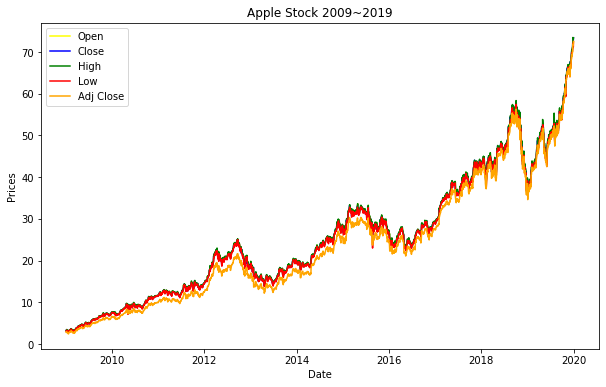

In [14]:
plt.figure(figsize=(10, 6))
color = ['yellow', 'blue', 'green', 'red', 'Orange']
y = ['Open', 'Close' , 'High', 'Low', 'Adj Close']
for i, c in zip(y, color):
  plt.plot(df['Date'], df[i], color=c, label=f'{i}')
  plt.title('Apple Stock 2009~2019')
  plt.xlabel('Date')
  plt.ylabel('Prices')
  plt.legend()

plt.show()

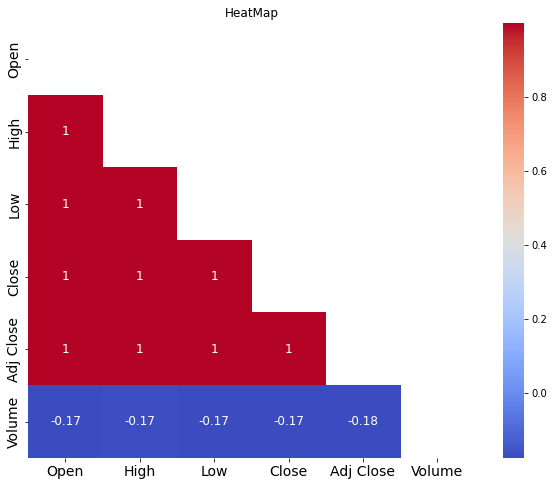

In [15]:
# Heatmap
fig = plt.figure(figsize=(10,8))
matrix = np.triu(data.corr())
ax = sns.heatmap(data.corr(),annot=True,annot_kws={"size":12},mask=matrix,cmap='coolwarm')
ax.tick_params(labelsize=14)
sns.set(font_scale=1)
ax.set_title('HeatMap')
plt.style.use('default')
plt.show()

In [16]:
y = df.drop(['Date','Volume'],axis = 1)

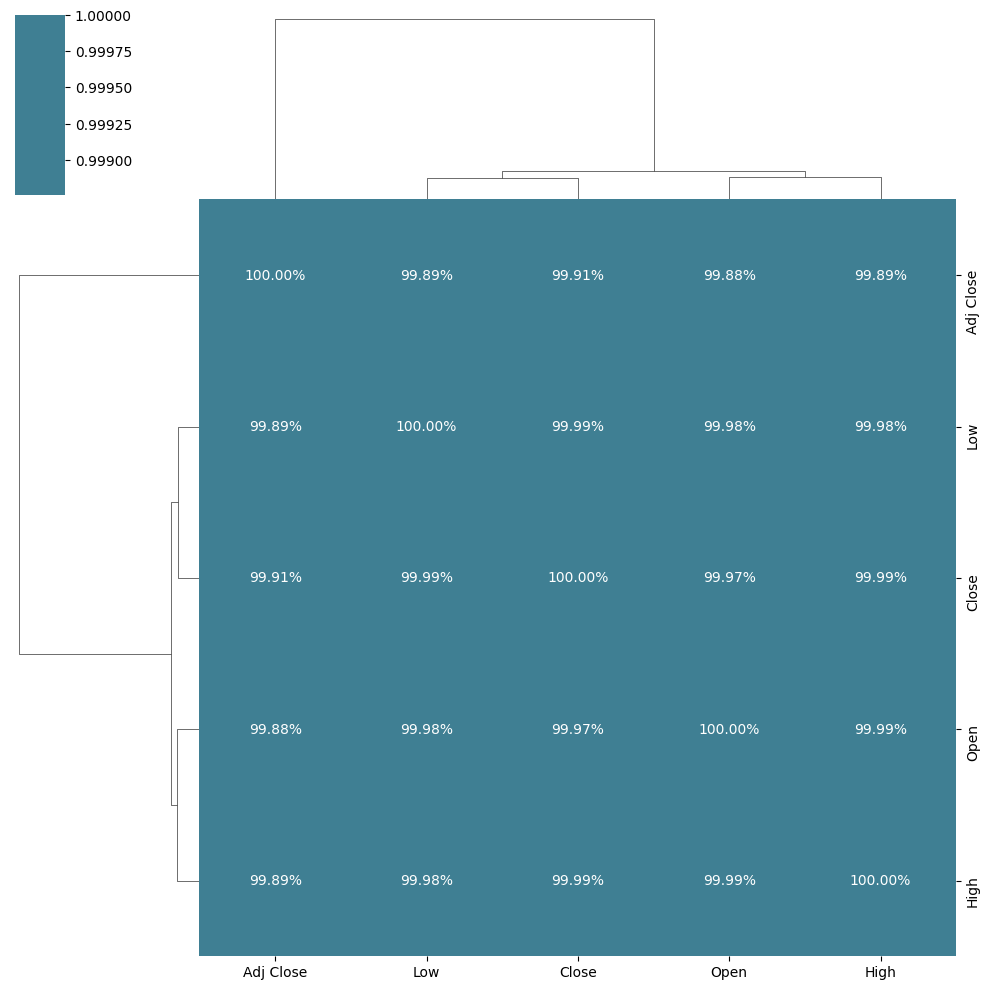

In [17]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');

# Split data

In [18]:
split = 0.8
train_data, test_data = df.iloc[0:int(len(df)*split), :], df.iloc[int(len(df)*split):, :]

In [19]:
train_dates = train_data['Date'] 
test_dates = test_data['Date']

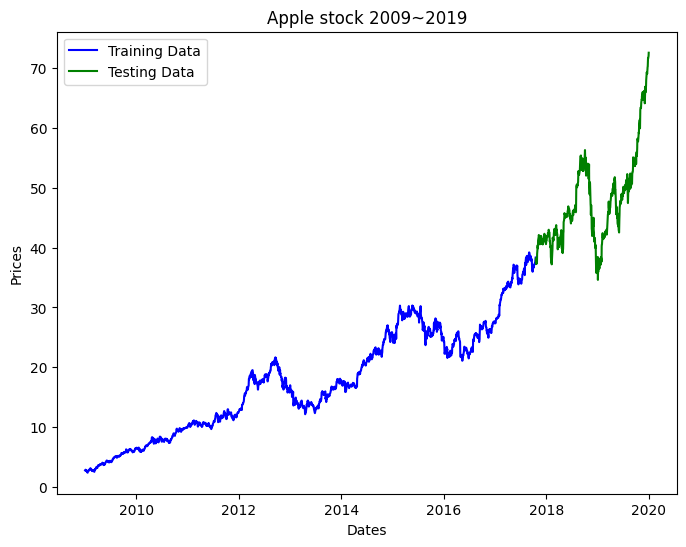

In [20]:
plt.figure(figsize=(8,6))
plt.title('Apple stock 2009~2019')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_dates, train_data['Adj Close'], 'blue', label='Training Data')
plt.plot(test_dates, test_data['Adj Close'], 'green', label='Testing Data')
plt.legend();

# Model

1.   ARIMA
2.   Seasonal ARIMA
3.   Linear Regress
4.   LSTM






##ARIMA

### Original Data


*   Rolling stats
*   AD-Fuller Stats



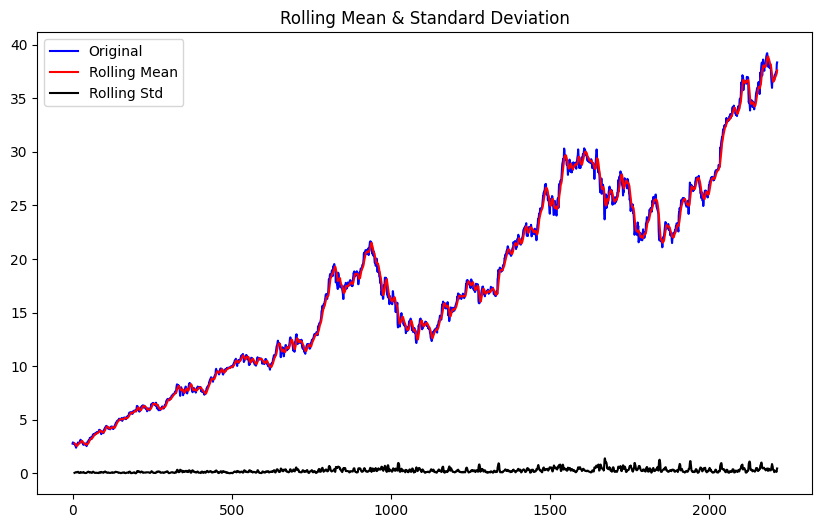

In [21]:
window = 7
train_series = train_data['Adj Close']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [22]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                    0.032161
p-value                           0.961112
#Lags Used                        0.000000
Number of Observations Used    2213.000000
Critical Value (1%)              -3.433308
Critical Value (5%)              -2.862847
Critical Value (10%)             -2.567466
dtype: float64

### Apply 1st order differencing


*   Rolling stats
*   AD-Fuller Stats



In [23]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)
train_diff.head(10)

1     0.117623
2    -0.047909
3    -0.061729
4     0.051902
5    -0.065107
6    -0.058965
7    -0.029176
8    -0.073091
9    -0.059886
10   -0.032247
Name: Adj Close, dtype: float64

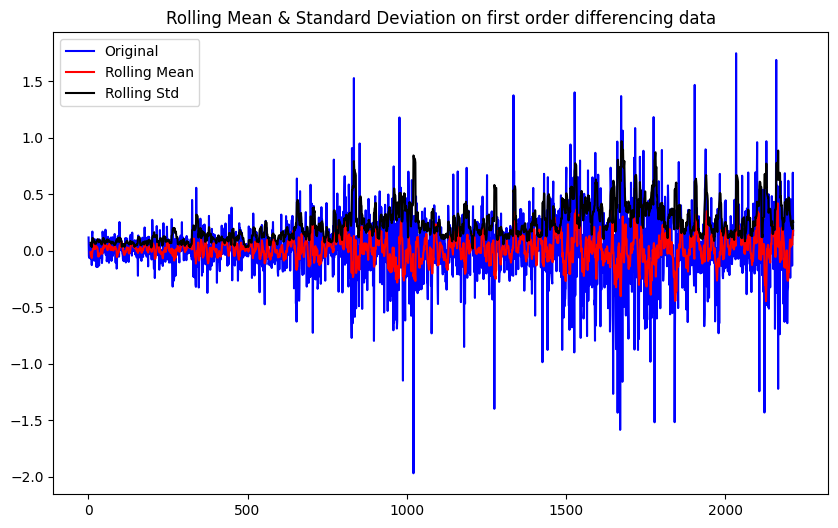

In [24]:
#Determing rolling statistics
diff_rolmean = train_diff.rolling(window).mean()
diff_rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
diff_orig = plt.plot(train_diff, color='blue',label='Original')
diff_mean = plt.plot(diff_rolmean, color='red', label='Rolling Mean')
diff_std = plt.plot(diff_rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation on first order differencing data');

In [25]:
diff_dftest = adfuller(train_diff, autolag='AIC')
diff_dfoutput = pd.Series(diff_dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in diff_dftest[4].items():
    diff_dfoutput['Critical Value (%s)'%key] = value
diff_dfoutput

Test Statistic                  -46.271995
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2212.000000
Critical Value (1%)              -3.433310
Critical Value (5%)              -2.862848
Critical Value (10%)             -2.567466
dtype: float64

In [26]:
arima_model = auto_arima(df['Adj Close'], start_p=1, start_q=1,
                           max_p=5, max_q=5, m=1,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(arima_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3271.226, Time=2.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3270.430, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3272.062, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3272.022, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3277.642, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.852 seconds
3270.430487710688


### Train model

In [27]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [28]:
#test_data.reset_index(drop=True,inplace=True)
test_series = test_data['Adj Close']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)
test_diff.head(10)

2215   -0.903244
2216    0.064518
2217   -0.019119
2218    0.222233
2219   -0.164887
2220    0.238957
2221    1.347698
2222    0.876964
2223    0.554371
2224   -0.513752
Name: Adj Close, dtype: float64

In [29]:
%%time 

history = [x for x in train_diff]
# From previous auto_arima result, best parameter (1,1,0)
best_params = (1,1,0)

predictions = list()
for t in range(len(test_diff)):
    model = ARIMA(history,order=best_params)
    # fit the model
    model_fit = model.fit()

    # use forecast on the fitted model
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    obs = test_diff.iloc[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=[0.40486811], Expected=-0.9032440000000008
Test Series Point: 100	Predicted=[-0.39304256], Expected=0.05056799999999839
Test Series Point: 200	Predicted=[0.2075841], Expected=-0.4737740000000059
Test Series Point: 300	Predicted=[-0.10379877], Expected=0.3675500000000014
Test Series Point: 400	Predicted=[-0.84787383], Expected=-0.16932700000000267
Test Series Point: 500	Predicted=[-0.11124092], Expected=-0.234016000000004
CPU times: user 27.4 s, sys: 447 ms, total: 27.8 s
Wall time: 28 s


### Performance

In [30]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.row_stack((test_series.iloc[0], predictions)).cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((554,), (554,))

In [31]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))

In [32]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 0.907
Symmetric Mean absolute percentage error: 1.522


### Visualize Prediction Results

In [33]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_test_diff)
reverse_predictions_series.index = test_series.index

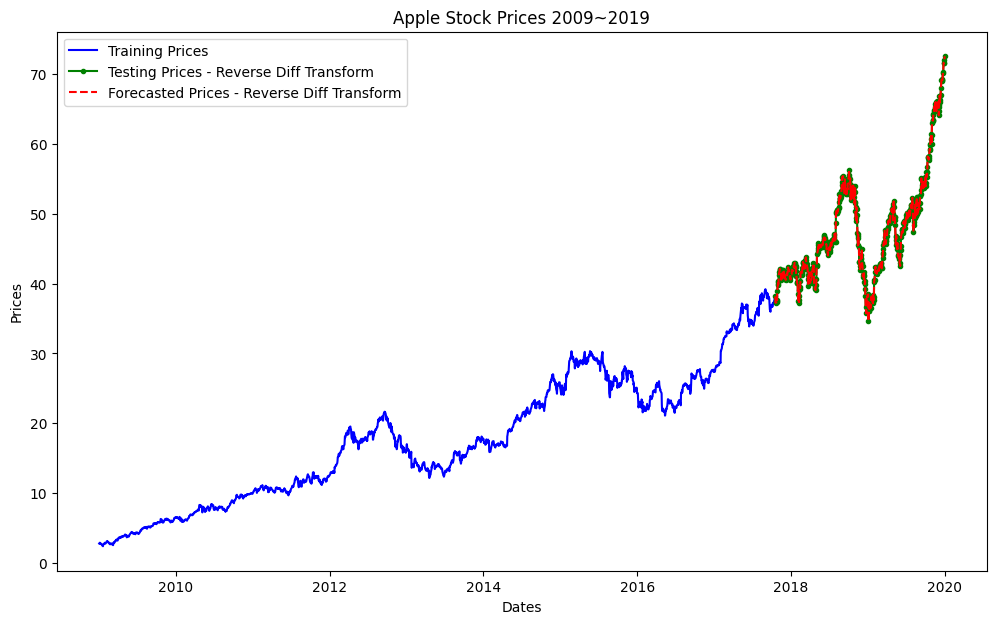

In [34]:
plt.figure(figsize=(12,7))
plt.title('Apple Stock Prices 2009~2019')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_dates, train_series, color='blue', label='Training Prices')
plt.plot(test_dates, reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(test_dates, reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

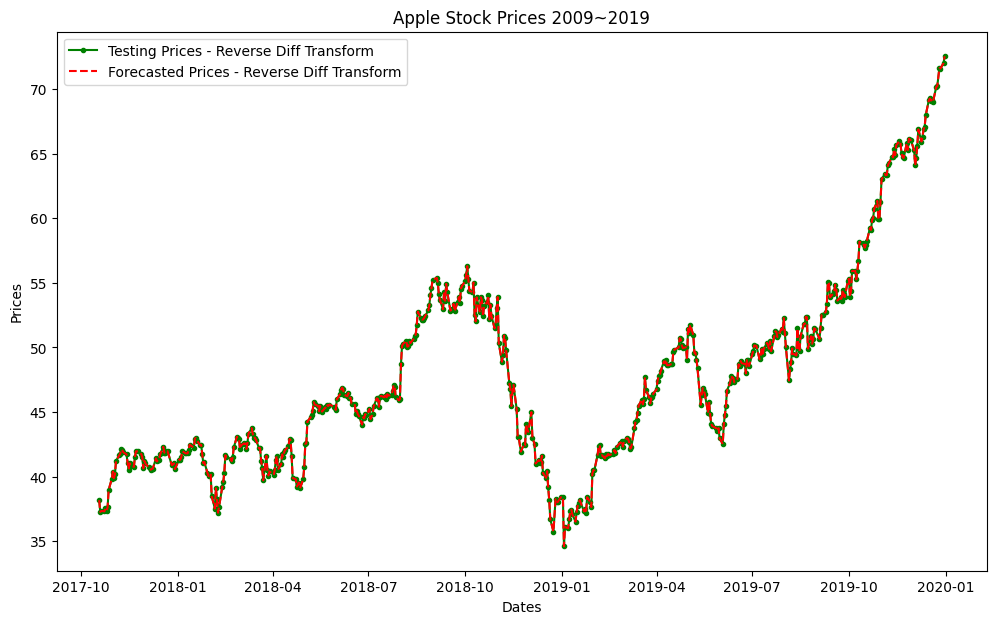

In [35]:
plt.figure(figsize=(12,7))
plt.title('Apple Stock Prices 2009~2019')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(test_dates, reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(test_dates, reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

## Seasonal ARIMA

### Resample to Monthly data

In [36]:
#date_df = df.reindex(columns=['Date','Open', 'Close' , 'High', 'Low', 'Adj Close','Volume'])
date_df = df
date_df.set_index('Date',inplace=True)
date_df['Date'] = date_df.index
date_df

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.787006,746015200,2009-01-02
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.904629,1181608400,2009-01-05
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.856720,1289310400,2009-01-06
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.794991,753048800,2009-01-07
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.846893,673500800,2009-01-08
...,...,...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,70.234581,48478800,2019-12-24
2019-12-26,71.205002,72.495003,71.175003,72.477501,71.628067,93121200,2019-12-26
2019-12-27,72.779999,73.492500,72.029999,72.449997,71.600876,146266000,2019-12-27


In [37]:
# Resample: Use the mean to represent the whole month's value
mon_avg = df['Adj Close'].resample('M').mean()
m_df = mon_avg.to_frame()
m_df

,Adj Close
Date,
2009-01-31,2.726353
2009-02-28,2.889096
2009-03-31,2.994458
2009-04-30,3.685941
2009-05-31,3.935560
...,...
2019-08-31,50.436246
2019-09-30,53.698802
2019-10-31,57.958231


In [38]:
mon_dftest = adfuller(m_df['Adj Close'], autolag='AIC')
mon_dfoutput = pd.Series(mon_dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in mon_dftest[4].items():
    mon_dfoutput['Critical Value (%s)'%key] = value
mon_dfoutput

Test Statistic                   1.822836
p-value                          0.998393
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

###Decompose the series

<Figure size 1000x600 with 0 Axes>

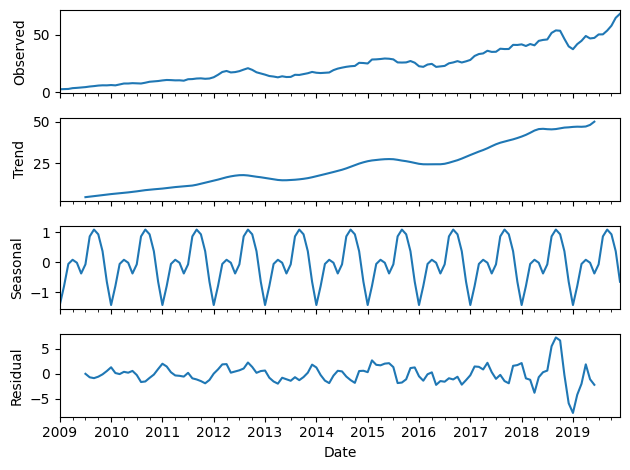

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd
plt.figure(figsize=(10,6))
decomposed_series = sd(m_df['Adj Close'],model='additive',freq=12)
decomposed_series.plot()
plt.show()

### First order differencing on monthly data

In [40]:
mon_series = m_df['Adj Close']
mon_diff = mon_series.diff()
mon_diff = mon_diff.dropna(inplace = False)
mon_diff.head(10)

Date
2009-02-28    0.162743
2009-03-31    0.105362
2009-04-30    0.691483
2009-05-31    0.249619
2009-06-30    0.349464
2009-07-31    0.300659
2009-08-31    0.520926
2009-09-30    0.353364
2009-10-31    0.462035
2009-11-30    0.229982
Freq: M, Name: Adj Close, dtype: float64

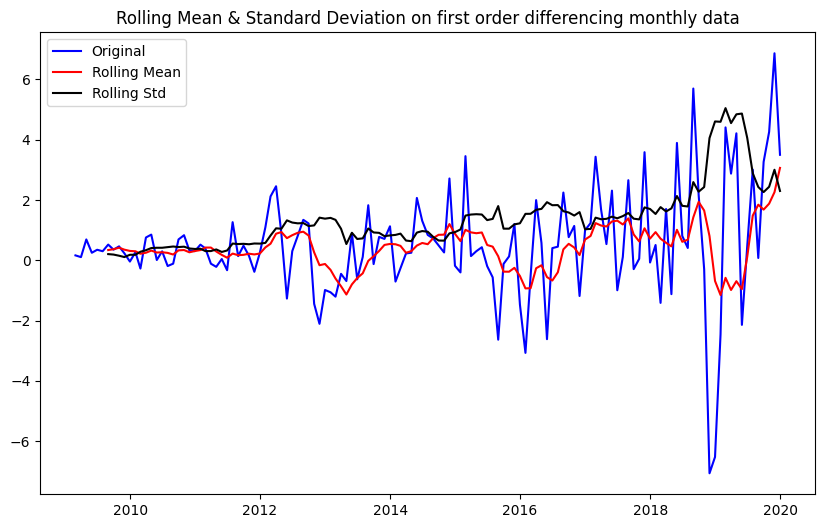

In [41]:
#Determing rolling statistics
mon_diff_rolmean = mon_diff.rolling(window).mean()
mon_diff_rolstd = mon_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
mon_diff_orig = plt.plot(mon_diff, color='blue',label='Original')
mon_diff_mean = plt.plot(mon_diff_rolmean, color='red', label='Rolling Mean')
mon_diff_std = plt.plot(mon_diff_rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation on first order differencing monthly data');

In [42]:
mon_diff_dftest = adfuller(mon_diff, autolag='AIC')
mon_diff_dfoutput = pd.Series(mon_diff_dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in mon_diff_dftest[4].items():
    mon_diff_dfoutput['Critical Value (%s)'%key] = value
mon_diff_dfoutput

Test Statistic                  -3.219332
p-value                          0.018893
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64

### Split Monthly Data

In [43]:
mon_train_data, mon_test_data = m_df.iloc[0:int(len(m_df)*split), :], m_df.iloc[int(len(m_df)*split):, :]

In [44]:
mon_train_series = mon_train_data['Adj Close']
mon_test_series = mon_test_data['Adj Close']

In [45]:
mon_train_series

Date
2009-01-31     2.726353
2009-02-28     2.889096
2009-03-31     2.994458
2009-04-30     3.685941
2009-05-31     3.935560
                ...    
2017-05-31    36.179810
2017-06-30    35.186622
2017-07-31    35.298049
2017-08-31    37.954008
2017-09-30    37.661080
Freq: M, Name: Adj Close, Length: 105, dtype: float64

### Use auto_arima to find the best parameter

In [46]:
seasonal_model = auto_arima(mon_train_series, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(seasonal_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=362.315, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=339.100, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=356.002, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=325.252, Time=0.45 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=313.224, Time=1.42 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=3.42 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=3.58 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.46 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=314.301, Time=1.88 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=313.238, Time=2.88 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=312.334, Time=1.20 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.85

### Train model

In [47]:
mon_train_diff = mon_train_series.diff()
mon_train_diff = mon_train_diff.dropna(inplace = False)

mon_test_diff = mon_test_series.diff()
mon_test_diff = mon_test_diff.dropna(inplace = False)

In [48]:
%%time 

#seasonal_history = [x for x in mon_train_diff]
seasonal_history = [x for x in mon_train_series]

# From previous auto_arima result, best parameter (0,1,1)(2,1,1)
ord = (0,1,1)
s_ord = (2,1,1,12)

seasonal_predictions = list()
#for t in range(len(mon_test_diff)):
for t in range(len(mon_test_series)):
    model = sm.tsa.statespace.SARIMAX(seasonal_history, trend='n', order=ord, seasonal_order=s_ord)
    # fit the model
    model_fit = model.fit()
    #print(model_fit.summary())

    seasonal_output = model_fit.forecast()
    seasonal_yhat = seasonal_output[0]
    seasonal_predictions.append(seasonal_yhat)

#    seasonal_obs = mon_test_diff.iloc[t]
    seasonal_obs = mon_test_series.iloc[t]
    seasonal_history.append(seasonal_obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, seasonal_yhat, seasonal_obs))

"""
    if t != test_len - 1 :
    # use forecast on the fitted model
      seasonal_output = model_fit.forecast()
      seasonal_yhat = seasonal_output[0]
      seasonal_predictions.append(seasonal_yhat)
    else :
      seasonal_output = model_fit.predict(start=test_len, end=test_len+period-1, dynamic= True)
      seasonal_yhat = seasonal_output[0:period]
      seasonal_predictions.extend(seasonal_yhat)
 """

Test Series Point: 0	Predicted=37.4477082492673, Expected=37.71096554545455
CPU times: user 39.1 s, sys: 29.3 s, total: 1min 8s
Wall time: 35 s


In [49]:
#sa_model = sm.tsa.statespace.SARIMAX(mon_train_series, trend='n', order=(0,1,1), seasonal_order=(2,1,1,12))
#seasonal_arima_model = sa_model.fit()
#print(seasonal_arima_model.summary())

In [50]:
#train_begin = '2009-01-31'
#train_end = '2017-09-30'
#test_begin = '2017-09-30'
#test_end = '2019-12-31'

In [51]:
#sonal_train_predictions = seasonal_arima_model.predict(start = train_begin, end= train_end, dynamic= True)
#seasonal_test_predictions = seasonal_arima_model.predict(start = test_begin, end= test_end, dynamic= True)  

In [52]:
seasonal_predictions

[37.4477082492673,
 38.12817508277351,
 42.11230604338388,
 40.53898638119158,
 43.152190256238804,
 40.13706329699195,
 42.525295496281,
 40.887919701382366,
 45.2747165697838,
 45.90159315000878,
 45.84062817553641,
 52.596210036398155,
 54.25556811279295,
 54.40891945131839,
 45.33848902879081,
 38.242682816489214,
 38.21475125737936,
 43.99836890277094,
 45.365614281297226,
 50.29199291710861,
 46.081649030130414,
 47.95788599161642,
 51.313352142296,
 50.373650755731944,
 55.00871283156037,
 60.389104804208294,
 67.60529029187134]

### Performance

In [53]:
"""
tmp = np.asarray([mon_test_series.iloc[0]]+seasonal_predictions)
seasonal_reverse_test_diff = np.r_[mon_test_series.iloc[0], mon_test_diff].cumsum()
seasonal_reverse_predictions = tmp.cumsum()
seasonal_reverse_test_diff.shape, seasonal_reverse_predictions.shape
"""

'\ntmp = np.asarray([mon_test_series.iloc[0]]+seasonal_predictions)\nseasonal_reverse_test_diff = np.r_[mon_test_series.iloc[0], mon_test_diff].cumsum()\nseasonal_reverse_predictions = tmp.cumsum()\nseasonal_reverse_test_diff.shape, seasonal_reverse_predictions.shape\n'

In [54]:
"""
seasonal_error = mean_squared_error(seasonal_reverse_test_diff, seasonal_reverse_predictions)
print('Testing Mean Squared Error: %.3f' % seasonal_error)
seasonal_error2 = smape_kun(seasonal_reverse_test_diff, seasonal_reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % seasonal_error2)
"""

"\nseasonal_error = mean_squared_error(seasonal_reverse_test_diff, seasonal_reverse_predictions)\nprint('Testing Mean Squared Error: %.3f' % seasonal_error)\nseasonal_error2 = smape_kun(seasonal_reverse_test_diff, seasonal_reverse_predictions)\nprint('Symmetric Mean absolute percentage error: %.3f' % seasonal_error2)\n"

In [55]:
"""
mon_train_series = pd.DataFrame(mon_train_series)
mon_test_series = pd.DataFrame(mon_test_series)

seasonal_train_prediction = pd.DataFrame(seasonal_train_prediction)
seasonal_test_predictions = pd.DataFrame(seasonal_test_predictions)
"""

'\nmon_train_series = pd.DataFrame(mon_train_series)\nmon_test_series = pd.DataFrame(mon_test_series)\n\nseasonal_train_prediction = pd.DataFrame(seasonal_train_prediction)\nseasonal_test_predictions = pd.DataFrame(seasonal_test_predictions)\n'

In [56]:
seasonal_error1 = mean_squared_error(mon_test_series, seasonal_predictions)
print('Seasonal Mean Squared Error: %.3f' % seasonal_error1)
seasonal_error2 = smape_kun(mon_test_series, seasonal_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % seasonal_error2)

Seasonal Mean Squared Error: 9.534
Symmetric Mean absolute percentage error: 5.175


### Visualize

In [57]:
mon_train_data.index

DatetimeIndex(['2009-01-31', '2009-02-28', '2009-03-31', '2009-04-30',
               '2009-05-31', '2009-06-30', '2009-07-31', '2009-08-31',
               '2009-09-30', '2009-10-31',
               ...
               '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30'],
              dtype='datetime64[ns]', name='Date', length=105, freq='M')

In [58]:
mon_train_dates = mon_train_data.index
mon_test_dates = mon_test_data.index

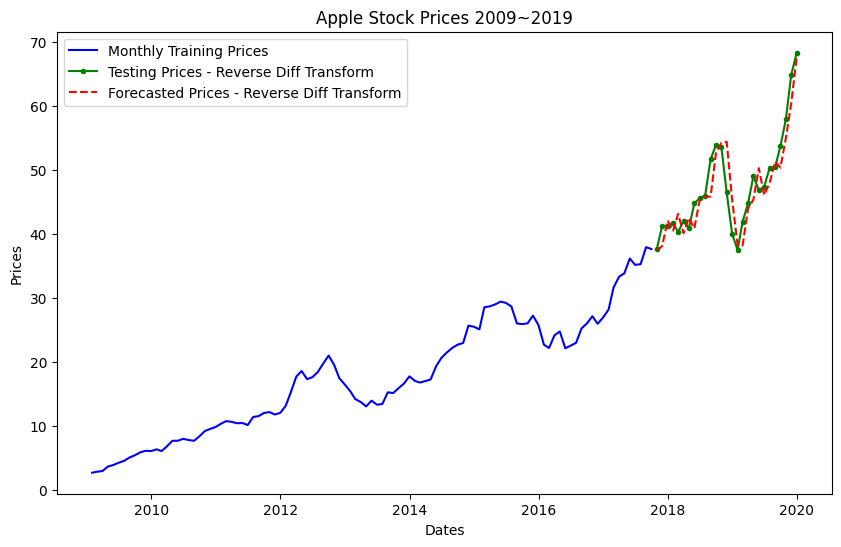

In [59]:
plt.figure(figsize=(10,6))
plt.title('Apple Stock Prices 2009~2019')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(mon_train_dates, mon_train_series, color='blue', label='Monthly Training Prices')
plt.plot(mon_test_dates, mon_test_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(mon_test_dates, seasonal_predictions , color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

In [60]:
"""
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,6))
seasonal_train_prediction.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
mon_train_series.plot(label='Actual',ax=ax1)
ax1.set_ylabel('Stock Price')
ax1.set_xlabel('Time')

seasonal_test_predictions.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
mon_test_series.plot(label='Actual',ax=ax2)
ax2.set_ylabel('Stock Price')
ax2.set_xlabel('Time')
"""

"\nfig,(ax1,ax2) = plt.subplots(2,figsize=(10,6))\nseasonal_train_prediction.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')\nmon_train_series.plot(label='Actual',ax=ax1)\nax1.set_ylabel('Stock Price')\nax1.set_xlabel('Time')\n\nseasonal_test_predictions.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')\nmon_test_series.plot(label='Actual',ax=ax2)\nax2.set_ylabel('Stock Price')\nax2.set_xlabel('Time')\n"

## LSTM

###Dataset Creation

In [61]:
# Normalization
sc = MinMaxScaler(feature_range=(0, 1))

train_series_scaled = sc.fit_transform(train_data[['Adj Close']])
test_series_scaled = sc.fit_transform(test_data[['Adj Close']])

In [62]:
# function to create dataset
def dataset_creation(dataset, window_size):
    
    X, y = [], []

    for i in range(len(dataset)-window_size-1):

        tmp_X = dataset[i : (i + window_size), 0]
        tmp_y = dataset[i + window_size, 0]

        X.append(tmp_X)
        y.append(tmp_y)
        
    return np.array(X), np.array(y)

In [63]:
win = 30
train_set, train_label = dataset_creation (train_series_scaled, win)
test_set, test_label = dataset_creation (test_series_scaled, win)

train_X = np.reshape(train_set, (train_set.shape[0], 1, train_set.shape[1]))
test_X = np.reshape(test_set, (test_set.shape[0], 1, test_set.shape[1]))

### Model

In [64]:
def create_model_1(input_shape):
    model = Sequential()
    model.add(LSTM(10, input_shape=(1, input_shape)))
  
    model.add(Dense(units = 1))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    
    return model 

In [65]:
def create_model_2(input_shape):
    model = Sequential()
    model.add(Bidirectional(GRU(50, return_sequences=True, input_shape=(input_shape, 1))))
    model.add(Bidirectional(GRU(50, return_sequences=True)))
    model.add(Bidirectional(GRU(50, return_sequences=True)))
    model.add(Bidirectional(GRU(50)))
    model.add(Dropout(0.2))
  
    model.add(Dense(units = 1))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    
    return model 

In [66]:
model_1 = create_model_1(win)
model_1.fit(train_X, 
          train_label, 
          epochs=20, 
          batch_size=1)

Epoch 1/20
2183/2183 [==============================] - 16s 4ms/step - loss: 0.0032 - mae: 0.0296 - mse: 0.0032
Epoch 2/20
2183/2183 [==============================] - 8s 4ms/step - loss: 5.7487e-04 - mae: 0.0177 - mse: 5.7487e-04
Epoch 3/20
2183/2183 [==============================] - 8s 4ms/step - loss: 4.1733e-04 - mae: 0.0151 - mse: 4.1733e-04
Epoch 4/20
2183/2183 [==============================] - 9s 4ms/step - loss: 3.4546e-04 - mae: 0.0136 - mse: 3.4546e-04
Epoch 5/20
2183/2183 [==============================] - 9s 4ms/step - loss: 3.2845e-04 - mae: 0.0132 - mse: 3.2845e-04
Epoch 6/20
2183/2183 [==============================] - 9s 4ms/step - loss: 2.6557e-04 - mae: 0.0118 - mse: 2.6557e-04
Epoch 7/20
2183/2183 [==============================] - 9s 4ms/step - loss: 2.6901e-04 - mae: 0.0120 - mse: 2.6901e-04
Epoch 8/20
2183/2183 [==============================] - 9s 4ms/step - loss: 2.5334e-04 - mae: 0.0117 - mse: 2.5334e-04
Epoch 9/20
2183/2183 [==============================] -

In [67]:
model_2 = create_model_2(win)
model_2.fit(train_X, 
          train_label, 
          epochs=20, 
          batch_size=1)

Epoch 1/20
2183/2183 [==============================] - 49s 17ms/step - loss: 0.0039 - mae: 0.0437 - mse: 0.0039
Epoch 2/20
2183/2183 [==============================] - 36s 17ms/step - loss: 0.0021 - mae: 0.0329 - mse: 0.0021
Epoch 3/20
2183/2183 [==============================] - 35s 16ms/step - loss: 0.0019 - mae: 0.0310 - mse: 0.0019
Epoch 4/20
2183/2183 [==============================] - 35s 16ms/step - loss: 0.0012 - mae: 0.0252 - mse: 0.0012
Epoch 5/20
2183/2183 [==============================] - 35s 16ms/step - loss: 0.0011 - mae: 0.0242 - mse: 0.0011
Epoch 6/20
2183/2183 [==============================] - 35s 16ms/step - loss: 0.0011 - mae: 0.0235 - mse: 0.0011
Epoch 7/20
2183/2183 [==============================] - 35s 16ms/step - loss: 0.0011 - mae: 0.0240 - mse: 0.0011
Epoch 8/20
2183/2183 [==============================] - 35s 16ms/step - loss: 8.3781e-04 - mae: 0.0214 - mse: 8.3781e-04
Epoch 9/20
2183/2183 [==============================] - 37s 17ms/step - loss: 9.5025e-04

### Prediction

In [68]:
train_prediction_1 = model_1.predict(train_X)
test_prediction_1 = model_1.predict(test_X)

train_prediction_2 = model_2.predict(train_X)
test_prediction_2 = model_2.predict(test_X)

In [69]:
# invert predictions
train_prediction_1 = sc.inverse_transform(train_prediction_1)
train_prediction_2 = sc.inverse_transform(train_prediction_2)
train_label = sc.inverse_transform([train_label])
test_prediction_1 = sc.inverse_transform(test_prediction_1)
test_prediction_2 = sc.inverse_transform(test_prediction_2)
test_label = sc.inverse_transform([test_label])

In [70]:
# calculate root mean squared error
train_rmse_1 = mean_squared_error(train_label[0], train_prediction_1[:,0])
print('Train RMSE for LSTM model 1: %.2f RMSE' % (train_rmse_1))
test_rmse_1 = mean_squared_error(test_label[0], test_prediction_1[:,0])
print('Test RMSE for LSTM model 1: %.2f RMSE' % (test_rmse_1))

train_rmse_2 = mean_squared_error(train_label[0], train_prediction_2[:,0])
print('Train RMSE for LSTM model 1: %.2f RMSE' % (train_rmse_2))
test_rmse_2 = mean_squared_error(test_label[0], test_prediction_2[:,0])
print('Test RMSE for LSTM model 1: %.2f RMSE' % (test_rmse_2))

Train RMSE for LSTM model 1: 0.21 RMSE
Test RMSE for LSTM model 1: 0.98 RMSE
Train RMSE for LSTM model 1: 0.29 RMSE
Test RMSE for LSTM model 1: 1.65 RMSE


In [116]:
b = np.full((len(train_prediction_1),1),test_series.head(1))

(2183, 1)

### Visualize

In [117]:
plot_train_predict_1 = np.empty_like(train_data[['Adj Close']])
plot_train_predict_1[:] = np.nan
plot_train_predict_1[win:len(train_prediction_1)+win] = train_prediction_1 - b 

plot_test_predict_1 = np.empty_like(test_data[['Adj Close']])
plot_test_predict_1[:] = np.nan
plot_test_predict_1[win:len(test_prediction_1)+win] = test_prediction_1

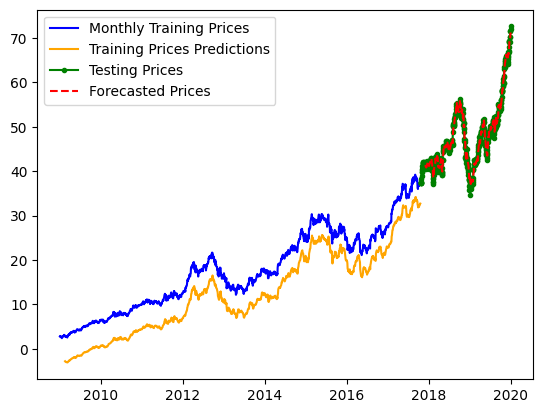

In [118]:
plt.plot(train_dates, train_series, color='blue', label='Monthly Training Prices')
plt.plot(train_dates, plot_train_predict_1, color='orange', label='Training Prices Predictions')
plt.plot(test_dates, test_series, color='green', marker='.', label='Testing Prices')
plt.plot(test_dates, plot_test_predict_1 , color='red', linestyle='--', label='Forecasted Prices')
plt.legend();

In [119]:
plot_train_predict_2 = np.empty_like(train_data[['Adj Close']])
plot_train_predict_2[:] = np.nan
plot_train_predict_2[win:len(train_prediction_1)+win] = train_prediction_2 - b 

plot_test_predict_2 = np.empty_like(test_data[['Adj Close']])
plot_test_predict_2[:] = np.nan
plot_test_predict_2[win:len(test_prediction_1)+win] = test_prediction_2

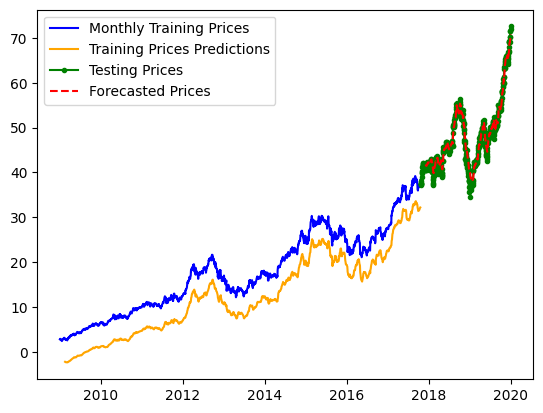

In [120]:
plt.plot(train_dates, train_series, color='blue', label='Monthly Training Prices')
plt.plot(train_dates, plot_train_predict_2, color='orange', label='Training Prices Predictions')
plt.plot(test_dates, test_series, color='green', marker='.', label='Testing Prices')
plt.plot(test_dates, plot_test_predict_2, color='red', linestyle='--', label='Forecasted Prices')
plt.legend();

## Facebook Prophet

### Prepare Dataset

In [75]:
prophet_df = m_df
prophet_df

,Adj Close
Date,
2009-01-31,2.726353
2009-02-28,2.889096
2009-03-31,2.994458
2009-04-30,3.685941
2009-05-31,3.935560
...,...
2019-08-31,50.436246
2019-09-30,53.698802
2019-10-31,57.958231


In [76]:
prophet_df['Date'] = prophet_df.index

In [77]:
prophet_df.rename(columns={'Date':'ds','Adj Close':'y'},inplace=True)
prophet_df

,y,ds
Date,,
2009-01-31,2.726353,2009-01-31
2009-02-28,2.889096,2009-02-28
2009-03-31,2.994458,2009-03-31
2009-04-30,3.685941,2009-04-30
2009-05-31,3.935560,2009-05-31
...,...,...
2019-08-31,50.436246,2019-08-31
2019-09-30,53.698802,2019-09-30
2019-10-31,57.958231,2019-10-31


In [78]:
train_prophet_df, test_prophet_df = prophet_df.iloc[0:int(len(prophet_df)*split), :], prophet_df.iloc[int(len(prophet_df)*split):, :]

### Train Model

In [79]:
p_model = Prophet(yearly_seasonality=True)
p_model.fit(train_prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [135]:
future= p_model.make_future_dataframe(periods=len(mon_test_series),freq='M')
future

,ds
0,2009-01-31
1,2009-02-28
2,2009-03-31
3,2009-04-30
4,2009-05-31
...,...
127,2019-08-31
128,2019-09-30
129,2019-10-31
130,2019-11-30


In [137]:
p_prediction = p_model.predict(future)

### Visualization

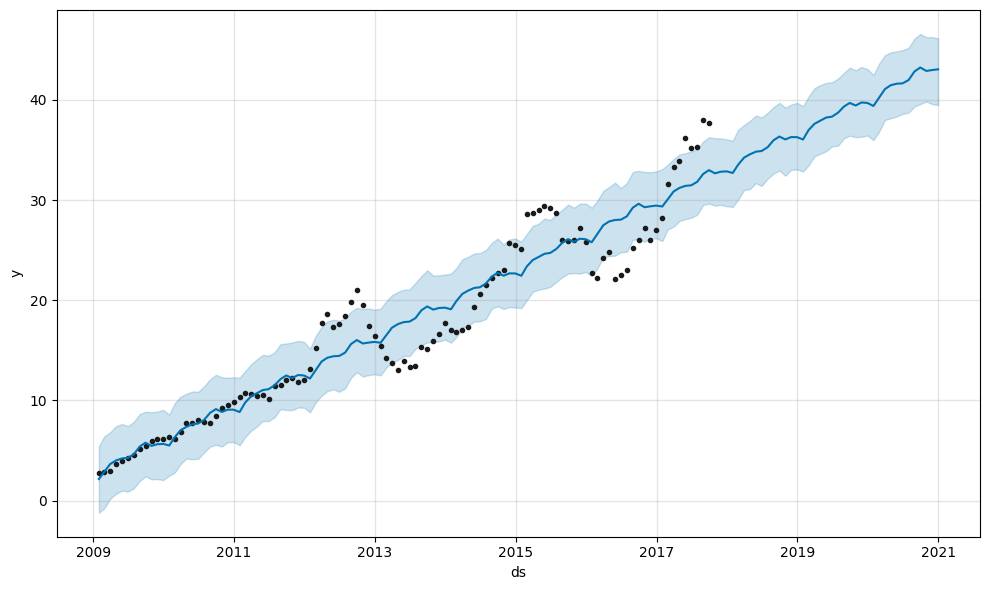

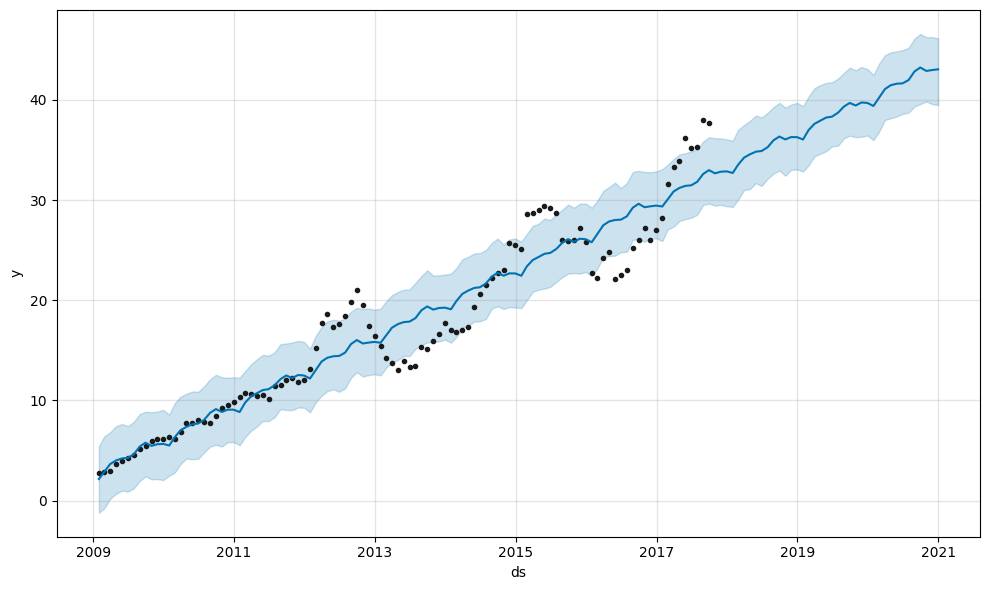

In [134]:
p_model.plot(p_prediction)

In [139]:
p_prediction.index = prophet_df.index

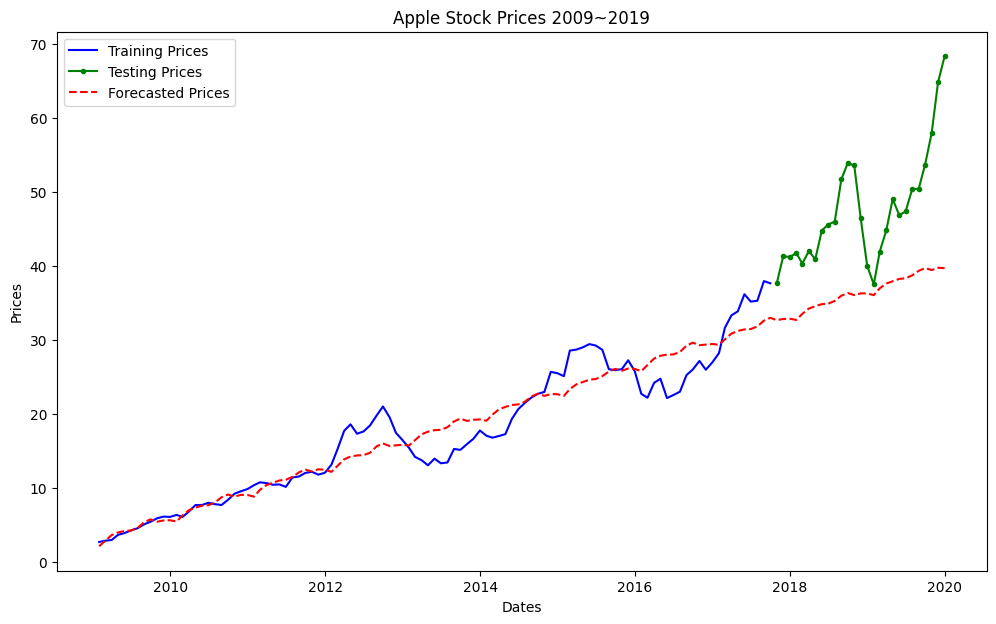

In [127]:
plt.figure(figsize=(12,7))
plt.title('Apple Stock Prices 2009~2019')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(mon_train_dates,mon_train_series, color='blue', label='Training Prices')
plt.plot(mon_test_dates, mon_test_series, color='green', marker='.', label='Testing Prices')
plt.plot(p_prediction['yhat'], color='red', linestyle='--', label='Forecasted Prices')
plt.legend();

### Performance

In [152]:
print('R2 Score : ',round(r2_score(test_prophet_df['y'],p_prediction['yhat'][len(train_prophet_df):]),3))
print('Mean Squared Error : ',round(mean_squared_error(test_prophet_df['y'],p_prediction['yhat'][len(train_prophet_df):]),3))
print('Mean Absolute Error : ',round(mean_absolute_error(test_prophet_df['y'],p_prediction['yhat'][len(train_prophet_df):]),3))

R2 Score :  -1.8
Mean Squared Error :  159.339
Mean Absolute Error :  11.074
